# Creating coordinates labels as masks for UNet

In [33]:
import numpy as np

from wings.config import PROCESSED_DATA_DIR
from wings.dataset import load_datasets
from wings.visualizing.image_preprocess import denormalize
from wings.visualizing.visualize import visualize_coords

train_val_test_datasets = load_datasets(
    [PROCESSED_DATA_DIR / 'train_dataset.pth',
     PROCESSED_DATA_DIR / 'val_dataset.pth',
     PROCESSED_DATA_DIR / 'test_dataset.pth']
)
_, _, test_dataset = train_val_test_datasets

In [34]:
max_n = len(test_dataset)
n = np.random.randint(0, max_n)
image, labels = test_dataset[n]
x_coords, y_coords = labels[::2].int(), labels[1::2].int()
y_coords = 224 - y_coords - 1
image = denormalize(image)

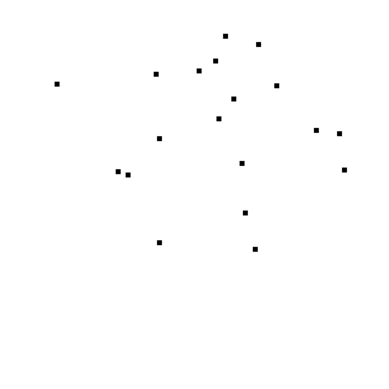

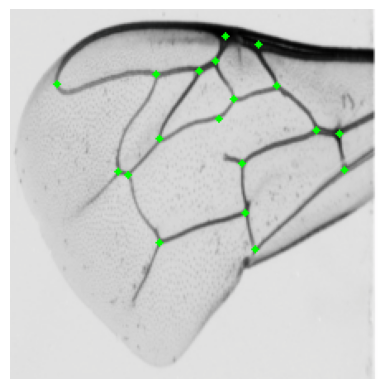

In [43]:
import numpy as np
from wings.visualizing.visualize import plt_imshow
import cv2

img_size = 224
square_size = 3

# Create a black image (grayscale)
# mask = np.zeros(image_size, dtype=np.uint8)
mask = np.full((img_size, img_size, 3), (255, 255, 255), dtype=np.uint8)

square_half = square_size // 2
for x, y in zip(x_coords, y_coords):
    x, y = int(x), int(y)
    # Calculate square bounds and clip them to image size
    top_left = (max(0, x - square_half), max(0, y - square_half))
    bottom_right = (min(img_size - 1, x + square_half), min(img_size - 1, y + square_half))

    cv2.rectangle(mask, top_left, bottom_right, color=(0, 0, 0), thickness=-1)

plt_imshow(mask)
visualize_coords(image, labels.squeeze(0), spot_size=2)


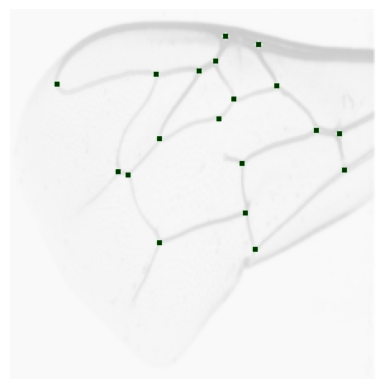

In [44]:
alpha = 0.8  # 0.0 - overlay niewidoczny, 1.0 - overlay całkowicie widoczny

# Nałóż obrazy
blended = cv2.addWeighted(mask, alpha, image, 1 - alpha, 0)
plt_imshow(blended)


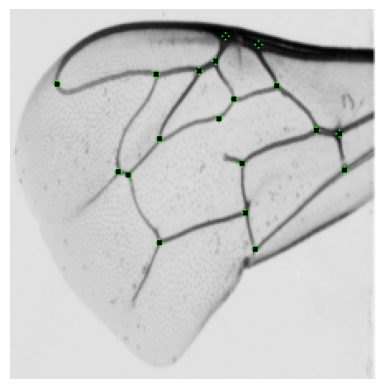

In [45]:
overlay_float = mask.astype(float)

whiteness = np.mean(overlay_float, axis=2) / 255.0

# Invert whiteness to get opacity: white => 0 (transparent), black => 1 (opaque)
alpha_mask = 1.0 - whiteness
alpha_mask = np.clip(alpha_mask, 0, 1)

# Convert alpha mask to 3 channels
alpha_mask_3ch = cv2.merge([alpha_mask] * 3)

# Blend manually
blended = (overlay_float * alpha_mask_3ch + image.astype(float) * (1 - alpha_mask_3ch)).astype(np.uint8)

plt_imshow(blended)
